In [77]:
#===================================================================================================

#Before running, check:
#    - ds_months is set to the correct months
#    - lev_sl_idx_min/max are set to chosen heights
#    - Set Time parameters 
#            - (search "**Set time parameters**" to find)  e.g. time_ind_2wk_min/max_val and time_it_shape (e.g. 2x 2wk time samples)
#            - Check times_str_min/max are set to the correct array size for the no of months in dataset

#===================================================================================================

import xarray as xr
import numpy as np
import cftime
import nc_time_axis
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib import ticker, cm
from cftime import datetime 
import matplotlib.colors as colors
import math
import random
import matplotlib.cm as mcm
jet = mcm.get_cmap('jet')
import cartopy.crs as ccrs # CRS stands for "Coordinate reference systems" for map projection
from cartopy.crs import PlateCarree
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from dateutil import tz
import pytz
import time
from time import process_time
%matplotlib inline 

#===================================================================================================
start_time = time.process_time() 
#===================================================================================================

#ds_months = ['12','01','02']
ds_months = ['12','01']
#ds_months = ['01']

ds_months_shape = len(ds_months)  #3
ds_months_ar = np.arange(0,ds_months_shape)   #[0,1,2]

#===================================================================================================
#**Set time parameters**

#No of time samples to iterate over (e.g. 2x 2 week periods)
time_it_shape = 2   

#--------------------------------------------------------------------------------------------------

time_ind_2wk_min = np.ndarray((time_it_shape), dtype = int)
time_ind_2wk_max = np.ndarray((time_it_shape), dtype = int)
time_ar_2wk = np.arange(0,time_it_shape)


#times_str_min = np.array( (time_ar_2wk,time_ar_2wk,time_ar_2wk) , dtype=str  ) 
#times_str_max = np.array( (time_ar_2wk,time_ar_2wk,time_ar_2wk) , dtype=str  ) 
times_str_min = np.array( (time_ar_2wk,time_ar_2wk) , dtype=str  ) 
times_str_max = np.array( (time_ar_2wk,time_ar_2wk) , dtype=str  ) 

#--------------------------------------------------------------------------------------------------

lat_shape = 96
lon_shape = 144

#===================================================================================================


for ids in ds_months_ar:
    file1name ='Nc_Files/Jianfei_WACCMX_files/waccmx_Fe_Fep_' + ds_months[ids] + '.nc'
    file2name='Nc_Files/Jianfei_WACCMX_files/waccmx_Z3_T_e_' + ds_months[ids] + '.nc'
    
    M = file1name[-9:]
    Metal=M[0:2]
    
    ds = xr.open_dataset(file1name)
    ds2 = xr.open_dataset(file2name)
    
    print('Dataset: Month ' + str(ds_months[ids]) )

    #===================================================================================================

    timee = ds.variables['time']
    start_cftime_date = '0001-' + str(ds_months[ids]) + '-01'
    times = xr.cftime_range(start=start_cftime_date, periods=672, freq="1H", calendar="noleap")    
    times2 = ds["time"].dt.strftime("%Y%m%d %H:%M")

    #===================================================================================================

    lon = ds.variables['lon']
    lat = ds.variables['lat']
    lev = ds.variables['lev']

    dst = ds.transpose("lev", ...)
    Mt = dst.variables[str(Metal)]
    Mpt = dst.variables[str(Metal)+'p']

    #===================================================================================================

    ds2t = ds2.transpose("lev", ...)
    temp = ds2t.variables['T']
    elect = ds2t.variables['e']

    geopH = ds2t.variables['Z3'] / 1000 #m-> km
    Zavg = geopH.mean(('time','lat', 'lon'))

    #===================================================================================================

    # Slice arrays (lev, altitude) between chosen range
    lev_sl_idx_min = 42
    lev_sl_idx_max = 66
    
    lev_shape = (lev_sl_idx_max-lev_sl_idx_min)+1
    
    lev_sl = lev[lev_sl_idx_min:lev_sl_idx_max+1]

    lev_sl_ind_min = lev[lev_sl_idx_min] 
    lev_sl_ind_max = lev[lev_sl_idx_max] 
    lev_sl_str = str("%.1e" % lev_sl_ind_max) + 'hPa : ' + str("%.1e" % lev_sl_ind_min) + 'hPa'
    
    Zavg_sl = Zavg[lev_sl_idx_min:lev_sl_idx_max+1]
    Zavg_sl_min = Zavg[lev_sl_idx_min] 
    Zavg_sl_max = Zavg[lev_sl_idx_max]
    Zavg_sl_str = str("%.0f" % Zavg_sl_max) + 'km : ' + str("%.0f" % Zavg_sl_min) + 'km'
    
    print('    Array lev = ' + lev_sl_str + ' (approx ' + Zavg_sl_str + ')'   )

    geopH_sl = geopH[lev_sl_idx_min:lev_sl_idx_max+1,:,:,:]

    #===================================================================================================
    #**Set time parameters**
    #No of timesteps in one time sample (e.g. two week period)
    time_ind_2wk_min_val = 0
    time_ind_2wk_max_val = 335
    
    time_shape = (time_ind_2wk_max_val-time_ind_2wk_min_val)+1
    
    #===================================================================================================

    Mptdens_sh = np.ndarray((lev_shape, time_shape, lat_shape, lon_shape, time_it_shape, ds_months_shape), dtype = float) #(25, 336, 96, 144, 2, 3)
    max_Mptdens_avg2 = np.ndarray((time_it_shape, ds_months_shape), dtype = float)
    argmax_Mptdens_avg2 = np.ndarray((time_it_shape, ds_months_shape), dtype = int)
    Mptdens_std_peak = np.ndarray((lev_shape,time_it_shape, ds_months_shape), dtype = float)
    std_max_Mptdens = np.ndarray((time_it_shape, ds_months_shape), dtype = float)
    Mptdens_diff = np.ndarray((lev_shape, time_shape, lat_shape, lon_shape, time_it_shape, ds_months_shape), dtype = float) 

    SpEs_sh_nan = np.empty((lev_shape, time_shape, lat_shape, lon_shape, time_it_shape, ds_months_shape))
    SpEs_sh_nan[:] = np.NaN
    SpEs = np.ndarray((lev_shape, time_shape, lat_shape, lon_shape, time_it_shape, ds_months_shape), dtype = float)

    SpEs_freq_bool = np.empty((lev_shape, time_shape, lat_shape, lon_shape, time_it_shape, ds_months_shape)) 
    
    SpEs_freq = np.empty((lev_shape, time_shape, lat_shape, lon_shape, time_it_shape, ds_months_shape))
    SpEs_freq_time = np.empty((lev_shape, lat_shape, lon_shape, time_it_shape, ds_months_shape)) 

    SpEs_Occ_Freq = np.ndarray((lev_shape, lat_shape, lon_shape, time_it_shape, ds_months_shape), dtype = float)   
    
    SpEs_Occ_Freq_temp = np.empty((lev_shape, lat_shape, 3, time_it_shape, ds_months_shape), dtype=float)  #10 min bins (144 lon) -> 30 min bins (48 lon)
    SpEs_Occ_Fr_b = np.empty((lev_shape, lat_shape, 48, time_it_shape, ds_months_shape), dtype=float)    #10 min bins (144 lon) -> 30 min bins (48 lon)

    SpEs_Occ_Fr_b_avg = np.ndarray((lev_shape, lat_shape, 48, ds_months_shape), dtype = float)  #Monthly avg at each height/lat/lon
    SpEs_Occ_Fr_b_avglev = np.ndarray((lat_shape, 48, ds_months_shape), dtype = float)  #Monthly avg over all levs
    
    SpEs_Occ_Fr_b_dsavg = np.ndarray((lev_shape, lat_shape, 48), dtype = float)   #Dataset avg at each height/lat/lon
    SpEs_Occ_Fr_b_dsavglev = np.ndarray((lat_shape, 48), dtype = float) #Dataset avg over all levs
    

    #===================================================================================================
    
    for it2 in time_ar_2wk:
        nadd = 336
        time_ind_2wk_min[it2] = time_ind_2wk_min_val 
        time_ind_2wk_max[it2] = time_ind_2wk_max_val

        time_ind_2wk_min_val = time_ind_2wk_min_val + nadd
        time_ind_2wk_max_val = time_ind_2wk_max_val + nadd

        #===================================================================================================
        
        # Slice arrays (time) between chosen range
        #Time slice 1: 0:335 = 0001-02-01 00:00:00 : 0001-02-14 23:00:00 #336
        #Time slice 2: 336:671 = 0001-02-15 00:00:00 : 0001-02-28 23:00:00 #336

        times_idx_min = time_ind_2wk_min[it2]
        times_idx_max = time_ind_2wk_max[it2]
        times_min = times[times_idx_min]
        times_max = times[times_idx_max]
        
        times_str_min[ids][it2] = str(times_min) #~~#
        times_str_max[ids][it2] = str(times_max) #~~#

        
        print( '      Time slice ' + str(it2+1) + ' = ' +times_str_min[ids][it2] + ' : ' + times_str_max[ids][it2] ) 

        
        #===================================================================================================
        
        # Slice temp by chosen alt range and time range (2 weeks of data)
        tempe = temp[lev_sl_idx_min:lev_sl_idx_max+1,times_idx_min:times_idx_max+1,:,:]
        Mp_t = Mpt[lev_sl_idx_min:lev_sl_idx_max+1,times_idx_min:times_idx_max+1,:,:]
        
        #===================================================================================================

        # VMR to number density calculation
        Mptdens = ( Mp_t * 1e-6 * 100 * lev_sl ) / (1.380503e-23 * tempe)

        #===================================================================================================

        # Create array with time info for each day 
        day = np.arange(0,24)

        # Create an array with offset needed for each UT time step (24h period)
        # Offset by 15 degrees lon, lon axis is in 2.5 degree intervals
        os =  day * 15 / 2.5 
        offset = np.empty(24, dtype=int) #Create offset array so it has same dims as day variable
        for d in day:
            offset[d] =  ( int(os[d]) ) #convert floats to ints to get integer number of indices to offset by

        # Stack multiple offset arrays to give offsets for consecutive days in the 2 week dataset 
        offset2 = np.stack((offset, offset, offset, offset, offset, offset, offset), axis=0)
        offset2 = np.reshape(offset2, (24*7))
        offset3 = np.stack((offset2, offset2), axis=0)
        offset3 = np.reshape(offset3, (168*2))

        #===================================================================================================
        
        #Iterate over timear, offsetting e density at each time by 15 degrees lon
        timear = np.arange(0,336) # 2 week iteration period - hourly data
        for it in timear:
            Mptdens_sh[:,it,:,:,it2,ids] = np.roll(Mptdens[:,it,:,:], offset3[it] , axis=2)
 
        #===================================================================================================
        
        # Calculate average of offset densities along time axis
        Mptdens_avg = np.mean(Mptdens_sh,  axis=1) #-> (25, 96, 144, 2, 3)

        # Calculate std dev of offset densities along time axis
        Mptdens_std = np.std(Mptdens_sh, axis=1) #-> (25, 96, 144, 2, 3)

        #===================================================================================================
        
        #Calculate global average of Mp dens as fct of lev, find max over lev dimension (peak of layer)
        #Calculate standard deviation of this global average layer profile over time dim, and also at max of layer

        Mptdens_avg0 =  np.mean(Mptdens_sh,  axis=2) #avg over lat dim -> (25, 336, 144, 2, 3)
        Mptdens_avg1 = np.mean(Mptdens_avg0, axis=2) #avg over lon dim -> (25, 336, 2, 3)
        Mptdens_avg2 = np.mean(Mptdens_avg1, axis=1) #avg over time dim -> (25, 2, 3)

        max_Mptdens_avg2[it2,ids] = np.amax(Mptdens_avg2[:,it2,ids], axis=0) # find max over lev dim
        
        max_Mptdens_avg2_print = np.round_(max_Mptdens_avg2[it2,ids], decimals=1) 
        print('          Global avg Metal layer peak = ' + str(max_Mptdens_avg2_print) + ' cm-3' ) #1205.80343702 for it2=0,ds=Feb

        argmax_Mptdens_avg2[it2,ids] = np.argmax(Mptdens_avg2[:,it2,ids], axis=0) # find index of max over lev dim
        
        #print('        Index of global avg Metal layer peak = ' + str(argmax_Mptdens_avg2[it2,ids])) #index 16 for it2=0,ds=Feb
        lev_sl_print = lev_sl[argmax_Mptdens_avg2[it2,ids]].to_numpy()
        lev_sl_printt = "{:.2e}".format(lev_sl_print)
        Zavg_sl_print = Zavg_sl[argmax_Mptdens_avg2[it2,ids]].to_numpy()
        Zavg_sl_printt = "{:.1f}".format(Zavg_sl_print)
        print('          Global avg Metal layer peak height = ' + str(lev_sl_printt) + 'hPa (~' + str(Zavg_sl_printt) + 'km' ) #index 16 for it2=0,ds=Feb
        
        #Std dev of global average layer over time dim
        Mptdens_std_peak[:,it2,ids] = np.std(Mptdens_avg1[:,:,it2,ids], axis=1) #find std dev of Mptdens_avg1 (dims lev, time, it2, ids) over time dim ->(25,2,3)
        std_max_Mptdens[it2,ids] = Mptdens_std_peak[ argmax_Mptdens_avg2[it2,ids], it2, ids ] #std dev at layer peak
        
        std_max_Mptdens_print = np.round_(std_max_Mptdens[it2,ids], decimals=1) 
        print('          Std Dev of global avg Metal layer peak = ' + str(std_max_Mptdens_print) + ' cm-3' ) #161.189181 for it2=0,ds=Feb
        
          
        #===================================================================================================
        # OLD CRITERIA TESTED:
            # SpEs_sh_1: (diff > x sigma) 
            # SpEs_sh: (diff > x sigma) & Mpt > glb average at height x
            # SpEs_sh_mx: ** (diff > x sigma) & (Mpt > glb average at height peak of glb avg layer) ** 
            # SpEs_sh_mx1: (Mpt > glb average at height peak of glb avg layer) 
            # SpEs_sh_mx2: (diff > 0.5 sigma) & (Mpt > glb average at height peak of glb avg layer)

        #(A) ( Diff > x sigma ) & ( Mpt > 3x glb average at height x ) & ( Mpt > 3x std dev at glb avg layer peak)  
        #(B) ( Diff > x sigma ) & ( Mpt > 3x glb average at height x ) & ( Mpt > 1x glb avg layer peak)   
        #(C) ( Diff > x sigma ) & ( Mpt > 3* grid box avg over time period ) & ( Mpt > 1x glb avg layer peak)
        #(D) ( Diff > x sigma ) & ( Mpt > 3* grid box avg over time period ) & ( Mpt > 3x std dev at glb avg layer peak)
        #(E) ( Diff > x sigma ) & ( Mpt > 3x glb average at height x )  & ( Mpt > 1* grid box avg over time period ) & ( Mpt > 1x glb avg layer peak) 
        #(F) ( Mpt > 3x glb average at height x ) & ( Mpt > 3x std dev at glb avg layer peak) 

        #===================================================================================================

        # Calculate difference between e density from model output and the average e density
        for it in timear:
            Mptdens_diff[:,it,:,:,it2,ids] = Mptdens_sh[:,it,:,:,it2,ids] - Mptdens_avg[:,:,:,it2,ids]

        #-----------------------------------------------------------------------
        sigma_val = 1   #1sigma~68%   1.5sigma~87%    2sigma~95%
        sigma_val_str = str(sigma_val)
        #-----------------------------------------------------------------------

        # Current criteria:
        #
        Crit_name = '(B)'

        # Where criteria set are met, set SpEs to Mptdens_sh, otherwise set to NaN
        levar = np.arange(0,25)
        for it in timear:
            for ilev in levar:
                SpEs[ilev,it,:,:,it2,ids] = np.where(  ( Mptdens_diff[ilev,it,:,:,it2,ids]>( sigma_val*Mptdens_std[ilev,:,:,it2,ids]) ) &     #( Diff > x sigma )
                                                 ( Mptdens_sh[ilev,it,:,:,it2,ids] > ( 3. * Mptdens_avg2[ilev,it2,ids] ) ) &          #( Mpt > 3x glb average at height x ) 
                                                 #( Mptdens_sh[ilev,it,:,:,it2,ids] > ( 3. * Mptdens_avg[ilev,:,:,it2,ids]) ) &         #( Mpt > 3* grid box avg over time period )
                                                 #( Mptdens_sh[ilev,it,:,:,it2,ids] > ( 1. * Mptdens_avg[ilev,:,:,it2,ids]) ) &         #( Mpt > 1* grid box avg over time period )
                                                 ( Mptdens_sh[ilev,it,:,:,it2,ids] > ( max_Mptdens_avg2[it2,ids]) )                    #( Mpt > 1x glb avg layer peak)                       
                                                 #( Mptdens_sh[ilev,it,:,:,it2,ids] > ( 3. * std_max_Mptdens[it2,ids] ) )               #( Mpt > 3x std dev at glb avg layer peak)

                                                              , Mptdens_sh[ilev,it,:,:,it2,ids] , SpEs_sh_nan[ilev,it,:,:,it2,ids] )

        #===================================================================================================
    
        #Calculate Occurence freq

        SpEs_freq_bool[:,:,:,:,it2,ids] = np.isfinite(SpEs[:,:,:,:,it2,ids]) #Where SpEs is a number, set to True, otherwise set to False
        SpEs_freq[:,:,:,:,it2,ids] = SpEs_freq_bool[:,:,:,:,it2,ids] *1. #Convert True/False to 1/0s -> (25,336,96,144,2,3)

        SpEs_freq_time[:,:,:,it2,ids] = np.sum(SpEs_freq[:,:,:,:,it2,ids], axis=1) #Sum over Time dim to give SpEs_sh_freq_time (total occurences in 2 week time period) -> (25,96,144,2,3)
        SpEs_Occ_Freq[:,:,:,it2,ids] = ( SpEs_freq_time[:,:,:,it2,ids] / time_shape ) *100.    #Divide by number of timesteps (336) to give occurence freq (%)  # (25,96,144,2)

        #===================================================================================================
        
        # Bin into 0.5h bins instead of 10 mins 
        # Calculation done after summing over time to get occurence freq (%). Gets same result as when rebinned before summing but much faster

        it_ar = np.arange(1,48) # array 1->47
        latar= np.arange(0,96)
        for ilev in levar:
            for ilat in latar:
                SpEs_Occ_Freq_temp[ilev,ilat,0,it2,ids] = SpEs_Occ_Freq[ilev,ilat,-1,it2,ids]    # (25,96,144,2,3)
                SpEs_Occ_Freq_temp[ilev,ilat,1,it2,ids] = SpEs_Occ_Freq[ilev,ilat,0,it2,ids]
                SpEs_Occ_Freq_temp[ilev,ilat,2,it2,ids] = SpEs_Occ_Freq[ilev,ilat,1,it2,ids]
                SpEs_Occ_Fr_b[ilev,ilat,0,it2,ids] = np.mean(SpEs_Occ_Freq_temp[ilev,ilat,:,it2,ids])
                for iit_ar in it_ar:
                    SpEs_Occ_Freq_temp[ilev,ilat,:,it2,ids] = SpEs_Occ_Freq[ilev,ilat,((iit_ar*3)-1):((iit_ar*3)+2),it2,ids]
                    SpEs_Occ_Fr_b[ilev,ilat,iit_ar,it2,ids] = np.mean(SpEs_Occ_Freq_temp[ilev,ilat,:,it2,ids])

        #===================================================================================================

    SpEs_Occ_Fr_b_avg[:,:,:,ids] = np.mean(SpEs_Occ_Fr_b[:,:,:,:,ids],  axis=3) #avg over it2 dim (avg both 2wk periods)   =Monthly avg   ->(25, 96, 48, 3)
    SpEs_Occ_Fr_b_avglev[:,:,ids] = np.mean(SpEs_Occ_Fr_b_avg[:,:,:,ids],  axis=0) #avg over lev dim   =Monthly avg over all heights   ->(96, 48, 3)

    
SpEs_Occ_Fr_b_dsavg[:,:,:] = np.mean(SpEs_Occ_Fr_b_avg[:,:,:,:],  axis=3) #avg over ids dim (avg all months)   =Whole Dataset avg   ->(25, 96, 48)
SpEs_Occ_Fr_b_dsavglev[:,:] = np.mean(SpEs_Occ_Fr_b_dsavg[:,:,:],  axis=0) #avg over lev dim ->(96, 48)
    
#===================================================================================================
end_time = time.process_time()
time_taken = end_time - start_time
time_taken_min = time_taken / 60.
print('========================================')
print('Calculation Time = ' + str(time_taken_min) + ' mins' )  #11.21 mins


Dataset: Month 12
    Array lev = 6.0e-03hPa : 1.5e-05hPa (approx 81km : 129km)
      Time slice 1 = 0001-12-01 00:00:00 : 0001-12-14 23:00:00
          Global avg Metal layer peak = 1081.5 cm-3
          Global avg Metal layer peak height = 8.05e-04hPa (~92.0km
          Std Dev of global avg Metal layer peak = 118.8 cm-3
      Time slice 2 = 0001-12-15 00:00:00 : 0001-12-28 23:00:00
          Global avg Metal layer peak = 1035.1 cm-3
          Global avg Metal layer peak height = 8.05e-04hPa (~92.0km
          Std Dev of global avg Metal layer peak = 142.4 cm-3
Dataset: Month 01
    Array lev = 6.0e-03hPa : 1.5e-05hPa (approx 81km : 127km)
      Time slice 1 = 0001-01-01 00:00:00 : 0001-01-14 23:00:00
          Global avg Metal layer peak = 891.4 cm-3
          Global avg Metal layer peak height = 8.05e-04hPa (~91.7km
          Std Dev of global avg Metal layer peak = 174.2 cm-3
      Time slice 2 = 0001-01-15 00:00:00 : 0001-01-28 23:00:00
          Global avg Metal layer peak = 105

In [78]:
#--------------Set value for ids for plot variables-----------------------
ids_plot = 1
str_ids_plot = str(ids_plot)
print('Plot month ' + str_ids_plot + ': ' + str(ds_months[ids_plot]) )

#--------------Set value for it2 for plot variables-----------------------
it2_plot = 0
str_it2_plot = str(it2_plot)
print('Plot time ' + str_it2_plot + ': ' + times_str_min[ids_plot][it2_plot] + ' : ' + times_str_max[ids_plot][it2_plot] )
print('----------------------------------------')

#-------------------Set up Local Time Ticks-------------------------------

timeconv = lon / 15
timeconv_plot = timeconv.to_numpy() 
timeconv_plot_ticks = np.arange(0,25, dtype=float)

#------------Set string values for sigma symbol to use in plot------------
sigma = '\u03C3'

#---------------------------------------------------------------------------------------------
#-----------------------------------Lev-LT plot setup ----------------------------------------
#---------------------------------------------------------------------------------------------
print('Lev-LT plot setup:')

lat_plot_idx = 21 #=-50.2   #37 #=-19.9    
lat_plot = lat[lat_plot_idx]
lat_plot_str = str("%.1f" % lat_plot) 
print('     Plot lat = ' + lat_plot_str)

lev_sl_idx_plot_min = 0
lev_sl_idx_plot_max = 24
lev_sl_plot_min = lev_sl[lev_sl_idx_plot_min]
lev_sl_plot_max = lev_sl[lev_sl_idx_plot_max]
lev_sl_plot_min_str = str("%.1e" % lev_sl_plot_min) + ' hPa'
lev_sl_plot_max_str = str("%.1e" % lev_sl_plot_max) + ' hPa'
print('      Plot Lev = ' + lev_sl_plot_max_str + ' : ' + lev_sl_plot_min_str)

Zavg_sl_plot_min = Zavg_sl[lev_sl_idx_plot_min]
Zavg_sl_plot_max = Zavg_sl[lev_sl_idx_plot_max]
Zavg_sl_plot_min_str = str("%.0f" % Zavg_sl_plot_min) + ' km'
Zavg_sl_plot_max_str = str("%.0f" % Zavg_sl_plot_max) + ' km'
print('      Approx Z = ' + Zavg_sl_plot_max_str + ' : ' + Zavg_sl_plot_min_str)

Zavg_sl_plott = Zavg_sl[lev_sl_idx_plot_min:lev_sl_idx_plot_max+1]
Zavg_sl_plott = Zavg_sl_plott.to_numpy()
Zavg_sl_plottt = np.round_(Zavg_sl_plott, decimals=0)

print('----------------------------------------')
print('Lat-LT plot setup:')

#---------------------------------------------------------------------------------------------
#-----------------------------------Lat-LT plot setup ----------------------------------------
#---------------------------------------------------------------------------------------------

lev_sl_idx_plot = 4    #14 4.9e-04hPa~95km  #8 1.1e-04hPa~105km  #4 4.0e-05 hPa~114km

lev_sl_plot = lev_sl[lev_sl_idx_plot]
lev_sl_plot_str = str("%.1e" % lev_sl_plot) + ' hPa'
print('      Plot Lev = ' + lev_sl_plot_str )

Zavg_sl_plot = Zavg_sl[lev_sl_idx_plot]
Zavg_sl_plot_str = str("%.0f" % Zavg_sl_plot) + ' km'
print('      Approx Z = ' + Zavg_sl_plot_str )

Plot month 1: 01
Plot time 0: 0001-01-01 00:00:00 : 0001-01-14 23:00:00
----------------------------------------
Lev-LT plot setup:
     Plot lat = -50.2
      Plot Lev = 6.0e-03 hPa : 1.5e-05 hPa
      Approx Z = 81 km : 127 km
----------------------------------------
Lat-LT plot setup:
      Plot Lev = 4.0e-05 hPa
      Approx Z = 113 km


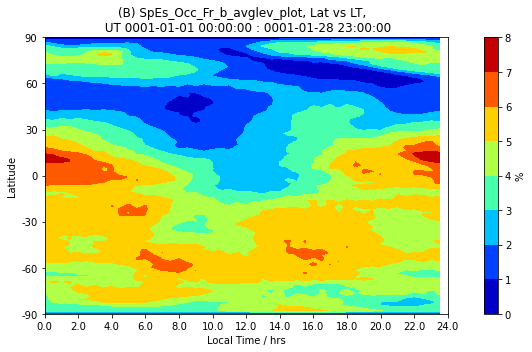

In [79]:
#Monthly avg over all heights (lat, LT, ids)

#---------------------------------------------------------------------------------------------------
#-----------------------------------Lat-LT----------------------------------------------------
#---------------------------------------------------------------------------------------------------


SpEs_Occ_Fr_b_avglev_plot = SpEs_Occ_Fr_b_avglev[:,:,ids_plot]

#-----------------------------------------------------

#ticks = np.linspace(0, 10, 21)
#ticks = np.linspace(0, 40, 21) #(F)

fig, ax = plt.subplots(figsize=(8, 5))

C = ax.contourf(timeconv_plot[::3], lat, SpEs_Occ_Fr_b_avglev_plot, 
                 #levels=ticks,
                 #locator=ticker.LogLocator(),
                 #extend='min',
                 cmap=jet)

ax.set_ylabel('Latitude')
ax.set_yticks(np.linspace(-90,90, 7)) 
ax.set_yticklabels((-90,-60,-30,0,30,60,90)) 

ax.set_xlabel('Local Time / hrs')
ax.set_xticks(np.linspace(0,24,13)) 
ax.set_xticklabels(timeconv_plot_ticks[::2]) 

ax.set_title(Crit_name +' '+ 'SpEs_Occ_Fr_b_avglev_plot, Lat vs LT, ' + ' \n UT ' + times_str_min[ids_plot][0] + ' : ' + times_str_max[ids_plot][-1] )

#ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
#plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

#------------------
def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

cbar = fig.colorbar(C, pad=0.07)#,ticks=ticks[::2])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
#-------------------

cbar.set_label(r'%')

figname= Crit_name +' '+ 'SpEs_Occ_Fr_b_avglev_plot: Lat vs LT, ' + ' ' + times_str_min[ids_plot][0] + ' : ' + times_str_max[ids_plot][-1] + '.png'
plt.tight_layout()
#plt.savefig('./Figures/Jianfei_run/SpE_Identification/Local_Time_Plots/'+ str(Metal)+'p/Occurence_freq/Lat-LT/test_22-04-13/'+str(figname), dpi = 400) #


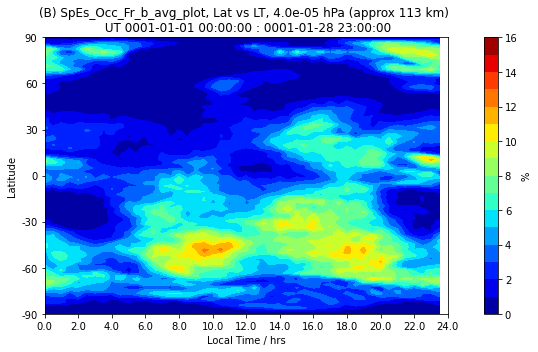

In [80]:
#Monthly avg   (lev, lat, LT, ids)

#---------------------------------------------------------------------------------------------------
#-----------------------------------Lat-LT----------------------------------------------------
#---------------------------------------------------------------------------------------------------


#---------------Set up plot variables----------------------------

SpEs_Occ_Fr_b_avg_plot = SpEs_Occ_Fr_b_avg[lev_sl_idx_plot,:,:,ids_plot] 


#-----------------------------------------------------

ticks = np.linspace(0, 16, 17)
#ticks = np.linspace(0, 40, 21) #(F)

fig, ax = plt.subplots(figsize=(8, 5))

C = ax.contourf(timeconv_plot[::3], lat, SpEs_Occ_Fr_b_avg_plot, 
                 levels=ticks,
                 #locator=ticker.LogLocator(),
                 #extend='min',
                 cmap=jet)

ax.set_ylabel('Latitude')
ax.set_yticks(np.linspace(-90,90, 7)) 
ax.set_yticklabels((-90,-60,-30,0,30,60,90)) 

ax.set_xlabel('Local Time / hrs')
ax.set_xticks(np.linspace(0,24,13)) 
ax.set_xticklabels(timeconv_plot_ticks[::2]) 

ax.set_title(Crit_name +' '+ 'SpEs_Occ_Fr_b_avg_plot, Lat vs LT, ' + lev_sl_plot_str + ' (approx '+ Zavg_sl_plot_str + ') \n UT ' + times_str_min[ids_plot][0] + ' : ' + times_str_max[ids_plot][-1] )

#ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
#plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

#------------------
def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

cbar = fig.colorbar(C, pad=0.07,ticks=ticks[::2])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
#-------------------

cbar.set_label(r'%')

figname= Crit_name +' '+ 'SpEs_Occ_Fr_b_avg_plot: Lat vs LT, ' + lev_sl_plot_str + ' ' + times_str_min[ids_plot][0] + ' : ' + times_str_max[ids_plot][-1] + '.png'
plt.tight_layout()
plt.savefig('./Figures/Jianfei_run/SpE_Identification/Local_Time_Plots/'+ str(Metal)+'p/Occurence_freq/Lat-LT/test_22-04-13/'+str(figname), dpi = 400) #


/tmp/ipykernel_3079298/1126052324.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(Zavg_sl_plottt[lev_sl_idx_plot_max:lev_sl_idx_plot_min:-5])
/tmp/ipykernel_3079298/1126052324.py:52: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(C, pad=0.12,ticks=ticks[::2])#,format=ticker.FuncFormatter(fmt))#fraction=0.023,


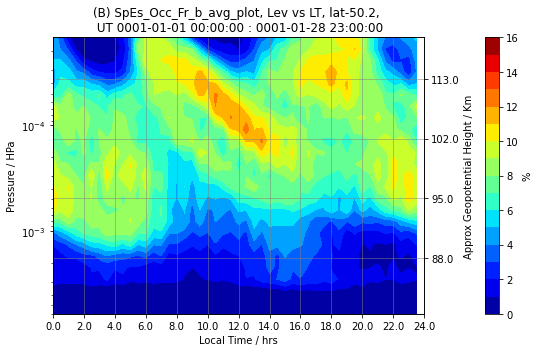

In [81]:
#Monthly avg   (lev, lat, LT, ids)

#---------------------------------------------------------------------------------------------------
#-----------------------------------Lev-LT----------------------------------------------------
#---------------------------------------------------------------------------------------------------


#---------------Set up plot variables----------------------------

SpEs_Occ_Fr_b_avg_plot = SpEs_Occ_Fr_b_avg[:,lat_plot_idx,:,ids_plot] 


#-----------------------------------------------------

ticks = np.linspace(0, 16, 17)
#ticks = np.linspace(0, 40, 21) #(F)

fig, ax = plt.subplots(figsize=(8, 5))

C = ax.contourf(timeconv_plot[::3], lev_sl, SpEs_Occ_Fr_b_avg_plot, 
                 levels=ticks,
                 #locator=ticker.LogLocator(),
                 #extend='min',
                 cmap=jet)

ax.set_yscale('log')
ax.set_ylabel('Pressure / HPa')
ax.set_ylim(lev_sl_plot_max, lev_sl_plot_min) 

ax2 = ax.twinx()
ax2.set_ylabel('Approx Geopotential Height / Km')
ax2.set_ylim(Zavg_sl_plot_max,Zavg_sl_plot_min)
ax2.set_yticklabels(Zavg_sl_plottt[lev_sl_idx_plot_max:lev_sl_idx_plot_min:-5])


ax.set_xlabel('Local Time / hrs')
ax.set_xticks(np.linspace(0,24,13)) 
ax.set_xticklabels(timeconv_plot_ticks[::2]) 

ax.set_title(Crit_name +' '+ 'SpEs_Occ_Fr_b_avg_plot, Lev vs LT, lat' + lat_plot_str + ', \n UT ' + times_str_min[ids_plot][0] + ' : ' + times_str_max[ids_plot][-1] )

ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
#ax.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)
plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

#------------------
def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

cbar = fig.colorbar(C, pad=0.12,ticks=ticks[::2])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
#-------------------

cbar.set_label(r'%')

figname= Crit_name +' '+ 'SpEs_Occ_Fr_b_avg_plot: Lev vs LT, lat' + lat_plot_str + ' ' + times_str_min[ids_plot][0] + ' : ' + times_str_max[ids_plot][-1] + '.png'
plt.tight_layout()
plt.savefig('./Figures/Jianfei_run/SpE_Identification/Local_Time_Plots/'+ str(Metal)+'p/Occurence_freq/Lev-LT/test_22-04-13/'+str(figname), dpi = 400) #


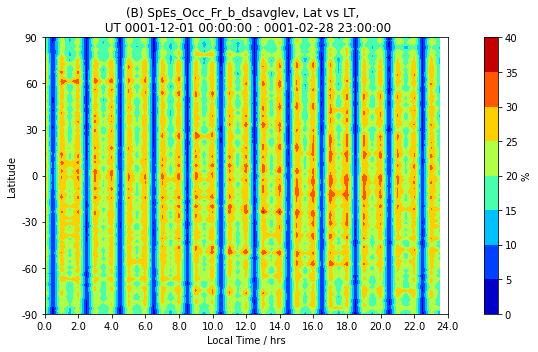

In [91]:
#Dataset avg over all heights (lat, LT)

#---------------------------------------------------------------------------------------------------
#-----------------------------------Lat-LT----------------------------------------------------
#---------------------------------------------------------------------------------------------------




#-----------------------------------------------------

#ticks = np.linspace(0, 10, 21)

fig, ax = plt.subplots(figsize=(8, 5))

C = ax.contourf(timeconv_plot[::3], lat, SpEs_Occ_Fr_b_dsavglev, 
                 #levels=ticks,
                 #locator=ticker.LogLocator(),
                 #extend='min',
                 cmap=jet)

ax.set_ylabel('Latitude')
ax.set_yticks(np.linspace(-90,90, 7)) 
ax.set_yticklabels((-90,-60,-30,0,30,60,90)) 

ax.set_xlabel('Local Time / hrs')
ax.set_xticks(np.linspace(0,24,13)) 
ax.set_xticklabels(timeconv_plot_ticks[::2]) 

ax.set_title(Crit_name +' '+ 'SpEs_Occ_Fr_b_dsavglev, Lat vs LT, ' + ' \n UT ' + times_str_min[0][0] + ' : ' + times_str_max[-1][-1] )

#ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
#plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

#------------------
def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

cbar = fig.colorbar(C, pad=0.07)#,ticks=ticks[::2])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
#-------------------

cbar.set_label(r'%')

figname= Crit_name +' '+ 'SpEs_Occ_Fr_b_dsavglev: Lat vs LT, ' + ' ' + times_str_min[0][0] + ' : ' + times_str_max[-1][-1] + '.png'
plt.tight_layout()
plt.savefig('./Figures/Jianfei_run/SpE_Identification/Local_Time_Plots/'+ str(Metal)+'p/Occurence_freq/Lat-LT/test_22-04-13/'+str(figname), dpi = 400) #


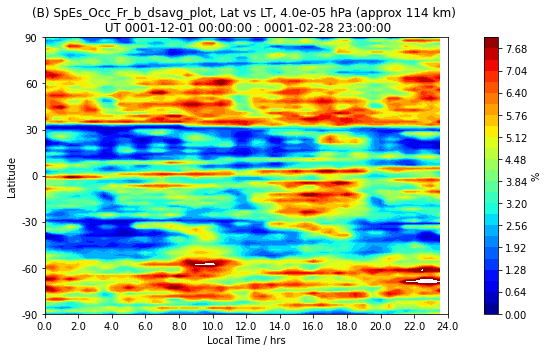

In [96]:
#Dataset avg   (lev, lat, LT)

#---------------------------------------------------------------------------------------------------
#-----------------------------------Lat-LT----------------------------------------------------
#---------------------------------------------------------------------------------------------------


#---------------Set up plot variables----------------------------

SpEs_Occ_Fr_b_dsavg_plot = SpEs_Occ_Fr_b_dsavg[lev_sl_idx_plot,:,:] 


#-----------------------------------------------------

ticks = np.linspace(0, 8, 26)
#ticks = np.linspace(0, 40, 21) #(F)

fig, ax = plt.subplots(figsize=(8, 5))

C = ax.contourf(timeconv_plot[::3], lat, SpEs_Occ_Fr_b_dsavg_plot, 
                 levels=ticks,
                 #locator=ticker.LogLocator(),
                 #extend='min',
                 cmap=jet)

ax.set_ylabel('Latitude')
ax.set_yticks(np.linspace(-90,90, 7)) 
ax.set_yticklabels((-90,-60,-30,0,30,60,90)) 

ax.set_xlabel('Local Time / hrs')
ax.set_xticks(np.linspace(0,24,13)) 
ax.set_xticklabels(timeconv_plot_ticks[::2]) 

ax.set_title(Crit_name +' '+ 'SpEs_Occ_Fr_b_dsavg_plot, Lat vs LT, ' + lev_sl_plot_str + ' (approx '+ Zavg_sl_plot_str + ') \n UT ' + times_str_min[0][0] + ' : ' + times_str_max[-1][-1] )

#ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
#plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

#------------------
def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

cbar = fig.colorbar(C, pad=0.07,ticks=ticks[::2])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
#-------------------

cbar.set_label(r'%')

figname= Crit_name +' '+ 'SpEs_Occ_Fr_b_dsavg_plot: Lat vs LT, ' + lev_sl_plot_str + ' ' + times_str_min[0][0] + ' : ' + times_str_max[-1][-1] + '.png'
plt.tight_layout()
#plt.savefig('./Figures/Jianfei_run/SpE_Identification/Local_Time_Plots/'+ str(Metal)+'p/Occurence_freq/Lat-LT/'+str(figname), dpi = 400) #


/tmp/ipykernel_3048716/1619356557.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(Zavg_sl_plottt[lev_sl_idx_plot_max:lev_sl_idx_plot_min:-5])
/tmp/ipykernel_3048716/1619356557.py:52: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(C, pad=0.12,ticks=ticks[::2])#,format=ticker.FuncFormatter(fmt))#fraction=0.023,


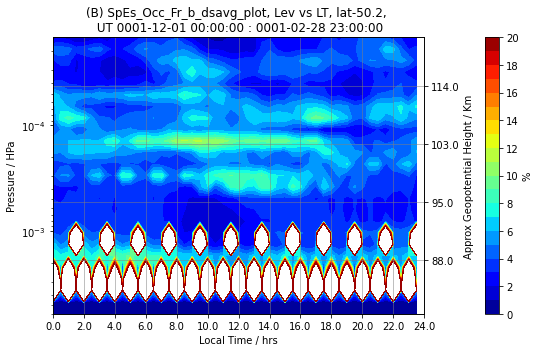

In [98]:
#Dataset avg   (lev, lat, LT, ids)

#---------------------------------------------------------------------------------------------------
#-----------------------------------Lev-LT----------------------------------------------------
#---------------------------------------------------------------------------------------------------


#---------------Set up plot variables----------------------------

SpEs_Occ_Fr_b_dsavg_plot = SpEs_Occ_Fr_b_dsavg[:,lat_plot_idx,:] 


#-----------------------------------------------------

ticks = np.linspace(0, 20, 21)
#ticks = np.linspace(0, 40, 21) #(F)

fig, ax = plt.subplots(figsize=(8, 5))

C = ax.contourf(timeconv_plot[::3], lev_sl, SpEs_Occ_Fr_b_dsavg_plot, 
                 levels=ticks,
                 #locator=ticker.LogLocator(),
                 #extend='min',
                 cmap=jet)

ax.set_yscale('log')
ax.set_ylabel('Pressure / HPa')
ax.set_ylim(lev_sl_plot_max, lev_sl_plot_min) 

ax2 = ax.twinx()
ax2.set_ylabel('Approx Geopotential Height / Km')
ax2.set_ylim(Zavg_sl_plot_max,Zavg_sl_plot_min)
ax2.set_yticklabels(Zavg_sl_plottt[lev_sl_idx_plot_max:lev_sl_idx_plot_min:-5])


ax.set_xlabel('Local Time / hrs')
ax.set_xticks(np.linspace(0,24,13)) 
ax.set_xticklabels(timeconv_plot_ticks[::2]) 

ax.set_title(Crit_name +' '+ 'SpEs_Occ_Fr_b_dsavg_plot, Lev vs LT, lat' + lat_plot_str + ', \n UT ' + times_str_min[0][0] + ' : ' + times_str_max[-1][-1] )

ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
#ax.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)
plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

#------------------
def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

cbar = fig.colorbar(C, pad=0.12,ticks=ticks[::2])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
#-------------------

cbar.set_label(r'%')

figname= Crit_name +' '+ 'SpEs_Occ_Fr_b_dsavg_plot: Lev vs LT, lat' + lat_plot_str + ' ' + times_str_min[0][0] + ' : ' + times_str_max[-1][-1] + '.png'
plt.tight_layout()
#plt.savefig('./Figures/Jianfei_run/SpE_Identification/Local_Time_Plots/'+ str(Metal)+'p/Occurence_freq/Lev-LT/'+str(figname), dpi = 400) #


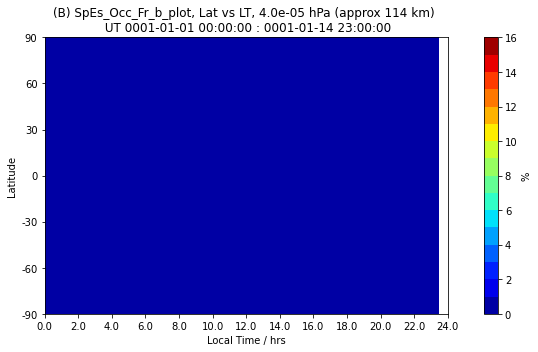

In [72]:
#2 week period  

#---------------------------------------------------------------------------------------------------
#-----------------------------------Lat-LT----------------------------------------------------
#---------------------------------------------------------------------------------------------------


#---------------Set up plot variables----------------------------


SpEs_Occ_Fr_b_plot = SpEs_Occ_Fr_b[lev_sl_idx_plot,:,:,it2_plot,ids_plot]

#-----------------------------------------------------

ticks = np.linspace(0, 16, 17)
#ticks = np.linspace(0, 40, 21) #(F)

fig, ax = plt.subplots(figsize=(8, 5))

C = ax.contourf(timeconv_plot[::3], lat, SpEs_Occ_Fr_b_plot, 
                 levels=ticks,
                 #locator=ticker.LogLocator(),
                 #extend='min',
                 cmap=jet)

ax.set_ylabel('Latitude')
ax.set_yticks(np.linspace(-90,90, 7)) 
ax.set_yticklabels((-90,-60,-30,0,30,60,90)) 

ax.set_xlabel('Local Time / hrs')
ax.set_xticks(np.linspace(0,24,13)) 
ax.set_xticklabels(timeconv_plot_ticks[::2]) 

ax.set_title(Crit_name +' '+ 'SpEs_Occ_Fr_b_plot, Lat vs LT, ' + lev_sl_plot_str + ' (approx '+ Zavg_sl_plot_str + ') \n UT ' + times_str_min[ids_plot][it2_plot] + ' : ' + times_str_max[ids_plot][it2_plot] )

#ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
#plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

#------------------
def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

cbar = fig.colorbar(C, pad=0.07,ticks=ticks[::2])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
#-------------------

cbar.set_label(r'%')

figname= Crit_name +' '+ 'SpEs_Occ_Fr_b_plot: Lat vs LT, ' + lev_sl_plot_str + ' ' + times_str_min[ids_plot][0] + ' : ' + times_str_max[ids_plot][-1] + '.png'
plt.tight_layout()
#plt.savefig('./Figures/Jianfei_run/SpE_Identification/Local_Time_Plots/'+ str(Metal)+'p/Occurence_freq/Lat-LT/test_22-04-13/'+str(figname), dpi = 400) #


/tmp/ipykernel_3079298/499556759.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(Zavg_sl_plottt[lev_sl_idx_plot_max:lev_sl_idx_plot_min:-5])
/tmp/ipykernel_3079298/499556759.py:48: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(C, pad=0.12)#,ticks=ticks[::2])#,format=ticker.FuncFormatter(fmt))#fraction=0.023,


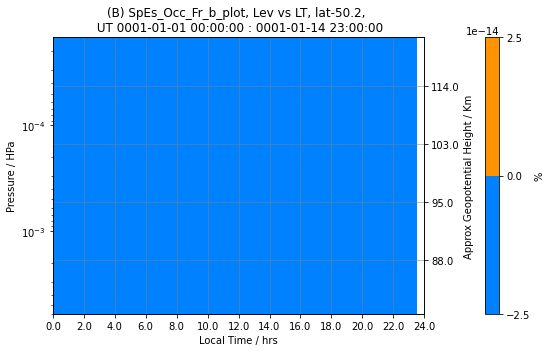

In [73]:
#2 week period  

#---------------------------------------------------------------------------------------------------
#-----------------------------------Lev-LT----------------------------------------------------
#---------------------------------------------------------------------------------------------------


#---------------Set up plot variables----------------------------

SpEs_Occ_Fr_b_plot = SpEs_Occ_Fr_b[:,lat_plot_idx,:,it2_plot,ids_plot] 

#------------------------ SpEs_Occ_Freq_plot -----------------------------

#ticks = np.linspace(0, 16, 17)

fig, ax = plt.subplots(figsize=(8, 5))

C = ax.contourf(timeconv_plot[::3], lev_sl, SpEs_Occ_Fr_b_plot, 
                 #levels=ticks,
                 #locator=ticker.LogLocator(),
                 #extend='min',
                 cmap=jet)

ax.set_yscale('log')
ax.set_ylabel('Pressure / HPa')
ax.set_ylim(lev_sl_plot_max, lev_sl_plot_min) 

ax2 = ax.twinx()
ax2.set_ylabel('Approx Geopotential Height / Km')
ax2.set_ylim(Zavg_sl_plot_max,Zavg_sl_plot_min)
ax2.set_yticklabels(Zavg_sl_plottt[lev_sl_idx_plot_max:lev_sl_idx_plot_min:-5])

ax.set_xlabel('Local Time / hrs')
ax.set_xticks(np.linspace(0,24,13)) 
ax.set_xticklabels(timeconv_plot_ticks[::2]) 

ax.set_title(Crit_name +' '+ 'SpEs_Occ_Fr_b_plot, Lev vs LT, lat' + lat_plot_str + ', \n UT ' + times_str_min[ids_plot][it2_plot] + ' : ' + times_str_max[ids_plot][it2_plot] )

ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

#------------------
def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

cbar = fig.colorbar(C, pad=0.12)#,ticks=ticks[::2])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
#-------------------

cbar.set_label(r'%')

figname= Crit_name +' '+ 'SpEs_Occ_Fr_b_plot: Lev vs LT, lat' + lat_plot_str + ' ' + times_str_min[ids_plot][it2_plot] + ' : ' + times_str_max[ids_plot][it2_plot] + '.png'
plt.tight_layout()
#plt.savefig('./Figures/Jianfei_run/SpE_Identification/Local_Time_Plots/'+ str(Metal)+'p/Occurence_freq/Lev-LT/+str(figname), dpi = 400) #



/tmp/ipykernel_3079298/3604303591.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(Zavg_sl_plottt[lev_sl_idx_plot_max:lev_sl_idx_plot_min:-5])
/tmp/ipykernel_3079298/3604303591.py:42: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(C, pad=0.12,ticks=ticks[::2])#,format=ticker.FuncFormatter(fmt))#fraction=0.023,


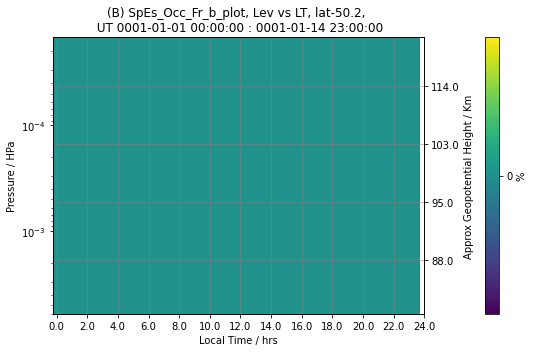

In [66]:
#2 week period  

#---------------------------------------------------------------------------------------------------
#-----------------------------------Lev-LT----------------------------------------------------
#---------------------------------------------------------------------------------------------------

#---------------Set up plot variables----------------------------

SpEs_Occ_Fr_b_plot = SpEs_Occ_Fr_b[:,lat_plot_idx,:,it2_plot,ids_plot] 

#-----------------------------------------------------

#ticks = np.linspace(0, 25, 26) #SpEs_Occ_Freq_plot

fig, ax = plt.subplots(figsize=(8, 5))
C = ax.pcolormesh(timeconv_plot[::3], lev_sl, SpEs_Occ_Fr_b_plot)

ax.set_yscale('log')
ax.set_ylabel('Pressure / HPa')
ax.set_ylim(lev_sl_plot_max, lev_sl_plot_min) 

ax2 = ax.twinx()
ax2.set_ylabel('Approx Geopotential Height / Km')
ax2.set_ylim(Zavg_sl_plot_max,Zavg_sl_plot_min)
ax2.set_yticklabels(Zavg_sl_plottt[lev_sl_idx_plot_max:lev_sl_idx_plot_min:-5])

ax.set_xlabel('Local Time / hrs')
ax.set_xticks(np.linspace(0,24,13)) 
ax.set_xticklabels(timeconv_plot_ticks[::2]) 

ax.set_title(Crit_name +' '+ 'SpEs_Occ_Fr_b_plot, Lev vs LT, lat' + lat_plot_str + ', \n UT ' + times_str_min[ids_plot][it2_plot] + ' : ' + times_str_max[ids_plot][it2_plot] )

ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

#------------------
def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

cbar = fig.colorbar(C, pad=0.12,ticks=ticks[::2])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
#-------------------

cbar.set_label(r'%')

figname= Crit_name +' '+ 'SpEs_Occ_Fr_b_plot' + '_pmesh: Lev vs LT, lat' + lat_plot_str + ' ' + times_str_min[ids_plot][it2_plot] + ' : ' + times_str_max[ids_plot][it2_plot] + '.png'
plt.tight_layout()
#plt.savefig('./Figures/Jianfei_run/SpE_Identification/Local_Time_Plots/'+ str(Metal)+'p/Occurence_freq/Lev-LT/'+str(figname), dpi = 400) #


/tmp/ipykernel_3048716/3433382476.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(Zavg_sl_plottt[lev_sl_idx_plot_max:lev_sl_idx_plot_min:-5])
/tmp/ipykernel_3048716/3433382476.py:40: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(C, pad=0.12)#,ticks=ticks[::4],format=ticker.FuncFormatter(fmt))#fraction=0.023,


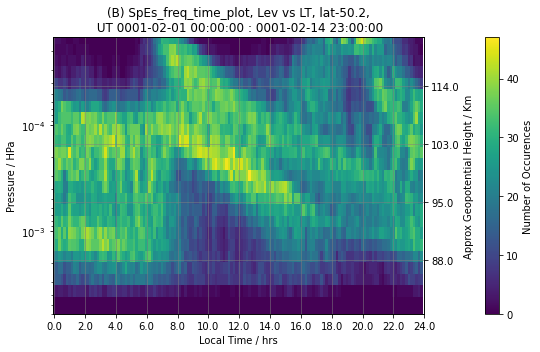

In [79]:
#2 week period  

#---------------------------------------------------------------------------------------------------
#-----------------------------------Lev-LT----------------------------------------------------
#---------------------------------------------------------------------------------------------------

#---------------Set up plot variables----------------------------
SpEs_freq_time_plot = SpEs_freq_time[:,lat_plot_idx,:,it2_plot,ids_plot]

#------------------------ SpEs_sh_freq_time_plot -----------------------------


fig, ax = plt.subplots(figsize=(8, 5))

C = ax.pcolormesh(timeconv_plot, lev_sl, SpEs_freq_time_plot)


ax.set_yscale('log')
ax.set_ylabel('Pressure / HPa')
ax.set_ylim(lev_sl_plot_max, lev_sl_plot_min) 

ax2 = ax.twinx()
ax2.set_ylabel('Approx Geopotential Height / Km')
ax2.set_ylim(Zavg_sl_plot_max,Zavg_sl_plot_min)
ax2.set_yticklabels(Zavg_sl_plottt[lev_sl_idx_plot_max:lev_sl_idx_plot_min:-5])

ax.set_xlabel('Local Time / hrs')
ax.set_xticks(np.linspace(0,24,13)) 
ax.set_xticklabels(timeconv_plot_ticks[::2]) 

ax.set_title(Crit_name +' '+ 'SpEs_freq_time_plot, Lev vs LT, lat' + lat_plot_str + ',\n UT ' + times_str_min[ids_plot][it2_plot] + ' : ' + times_str_max[ids_plot][it2_plot] )

ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

#------------------
def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

cbar = fig.colorbar(C, pad=0.12)#,ticks=ticks[::4],format=ticker.FuncFormatter(fmt))#fraction=0.023, 
#-------------------

cbar.set_label(r'Number of Occurences')

figname= Crit_name +' '+ 'SpEs_freq_time_plot: Lev vs LT, lat' + lat_plot_str + ' ' + times_str_min[ids_plot][it2_plot] + ' : ' + times_str_max[ids_plot][it2_plot] + '.png'
plt.tight_layout()
#plt.savefig('./Figures/Jianfei_run/SpE_Identification/Local_Time_Plots/'+ str(Metal)+'p/Occurence_freq/Lev-LT/'+str(figname), dpi = 400) #



/tmp/ipykernel_3079298/3510834009.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(Zavg_sl_plottt[lev_sl_idx_plot_max:lev_sl_idx_plot_min:-5])
/tmp/ipykernel_3079298/3510834009.py:63: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(C, pad=0.12)#,ticks=ticks[::4],format=ticker.FuncFormatter(fmt))#fraction=0.023,
/tmp/ipykernel_3079298/3510834009.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(Zavg_sl_plottt[lev_sl_idx_plot_max:lev_sl_idx_plot_min:-5])
/tmp/ipykernel_3079298/3510834009.py:63: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar. 

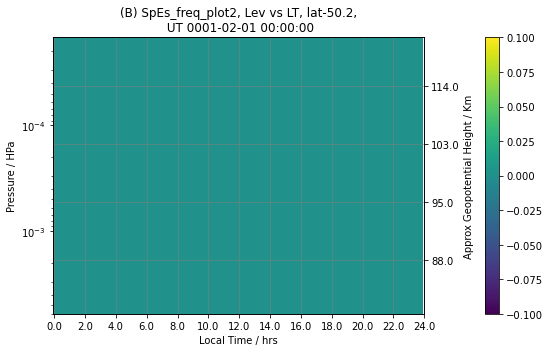

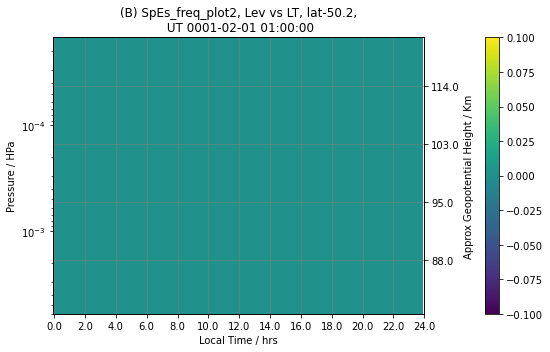

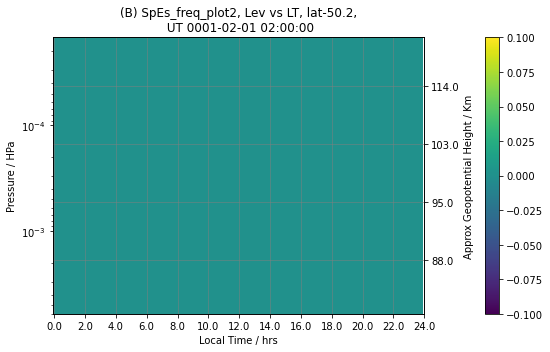

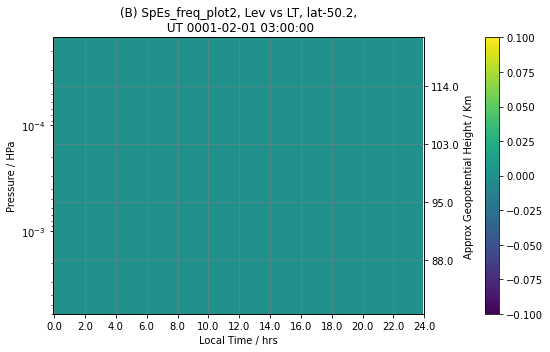

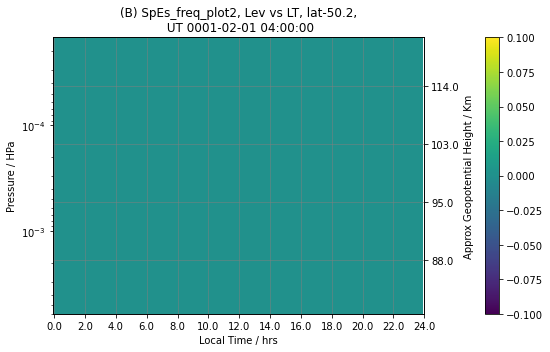

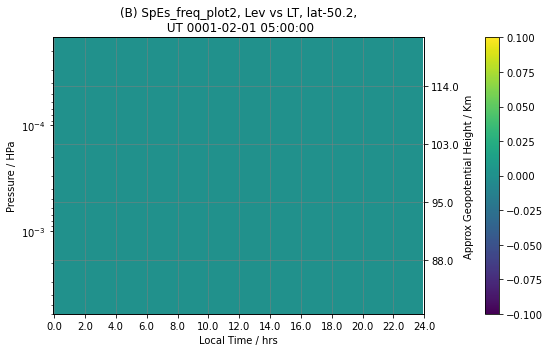

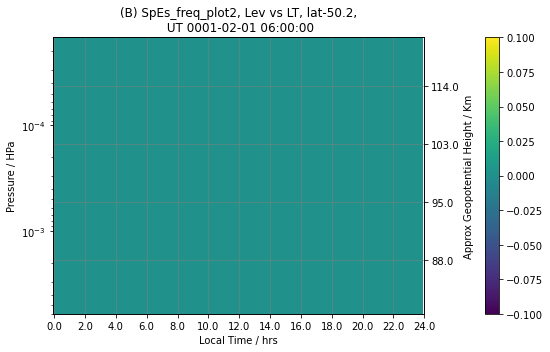

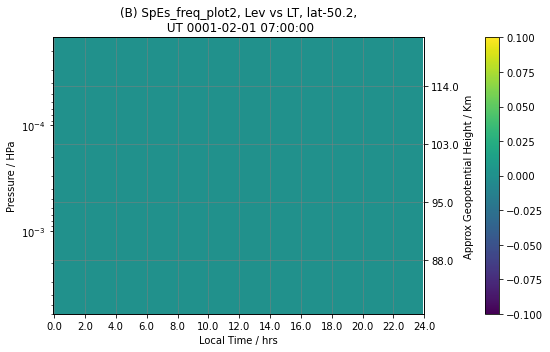

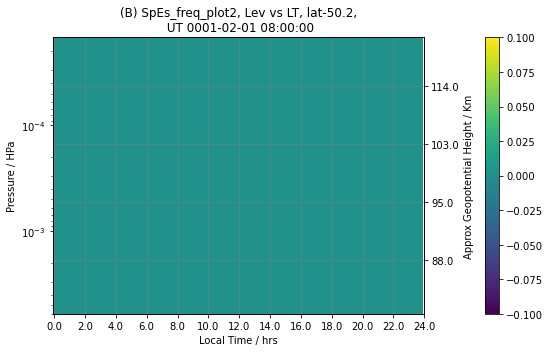

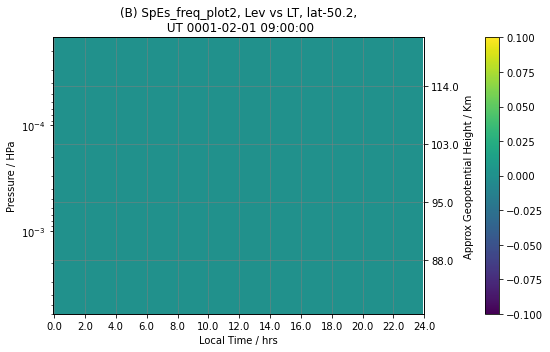

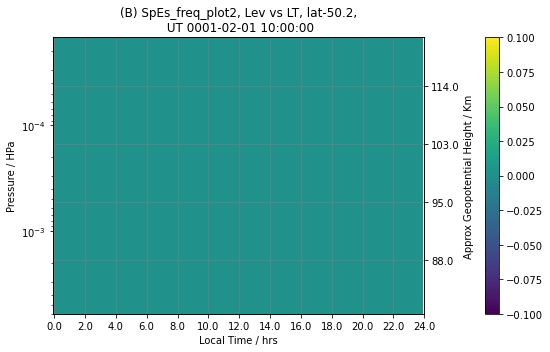

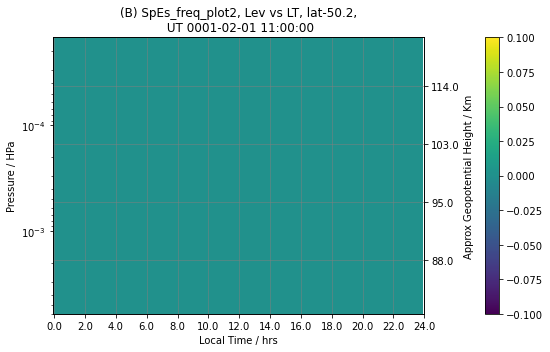

In [70]:
#Individual timesteps during 2 week period  

#---------------------------------------------
#Set number of plots to create
time_plot2_ntimesteps = 12
#---------------------------------------------




#---------------------------------------------------------------------------------------------------
#-----------------------------------Lev-LT----------------------------------------------------
#---------------------------------------------------------------------------------------------------

time_plot2_idx_start = time_ind_2wk_min[it2_plot]
time_plot2_idx_end = time_ind_2wk_min[it2_plot] + time_plot2_ntimesteps

time_plot2_ar = np.arange(time_plot2_idx_start,time_plot2_idx_end)  #e.g. 336,337,338 for it2_plot=1 n=3

time_arr = np.arange(0,time_plot2_ntimesteps)
#time_plot2_ar = np.arange(0,time_plot2_ntimesteps) 

#for itime in time_plot2_ar:
for itime in time_arr:
    time_plot2_idx = time_plot2_ar[itime]
    
    #--------------- Plot setup: time -------------------------
    time_plot2 = timee[time_plot2_idx]
    times_plot2 = times[time_plot2_idx]
    times_plot2_str = str(times_plot2)
    #print('Plot time = ' + times_plot2_str)   
    
    #---------------Set up plot variables----------------------------
    SpEs_freq_bool_plot2 = SpEs_freq_bool[:,itime,lat_plot_idx,:,it2_plot,ids_plot]
    SpEs_freq_plot2 = SpEs_freq[:,itime,lat_plot_idx,:,it2_plot,ids_plot]
    
    #------------------------ SpEs_sh_freq_time_plot -----------------------------

    #ticks = np.linspace(0, 40, 33)

    fig, ax = plt.subplots(figsize=(8, 5))
                      
    C = ax.pcolormesh(timeconv_plot, lev_sl, SpEs_freq_plot2)

    ax.set_yscale('log')
    ax.set_ylabel('Pressure / HPa')
    ax.set_ylim(lev_sl_plot_max, lev_sl_plot_min) 

    ax2 = ax.twinx()
    ax2.set_ylabel('Approx Geopotential Height / Km')
    ax2.set_ylim(Zavg_sl_plot_max,Zavg_sl_plot_min)
    ax2.set_yticklabels(Zavg_sl_plottt[lev_sl_idx_plot_max:lev_sl_idx_plot_min:-5])

    ax.set_xlabel('Local Time / hrs')
    ax.set_xticks(np.linspace(0,24,13)) 
    ax.set_xticklabels(timeconv_plot_ticks[::2]) 

    ax.set_title(Crit_name +' '+ 'SpEs_freq_plot2, Lev vs LT, lat' + lat_plot_str + ',\n UT ' + times_plot2_str )
    
    ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
    plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)
    
    cbar = fig.colorbar(C, pad=0.12)#,ticks=ticks[::4],format=ticker.FuncFormatter(fmt))#fraction=0.023, 
    #-------------------

    #cbar.set_label(r'Number of Occurences')

    figname= Crit_name +' '+ 'SpEs_freq_plot2: Lev vs LT, lat' + lat_plot_str + ' ' + times_plot2_str + '.png'
    plt.tight_layout()
    #plt.savefig('./Figures/Jianfei_run/SpE_Identification/Local_Time_Plots/'+ str(Metal)+'p/Occurence_freq/Lev-LT/'+str(figname), dpi = 400) #
    

In [ ]:
#------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------

In [79]:
#------------------------ Plot 1 setup: SpEs_plot-----------------------------

lev_sl_plot1_idx = 3    #3#~117km   #15 #~94km      #23=82km low lim?
lev_sl_plot1 = lev_sl[lev_sl_plot1_idx]
lev_sl_plot1_str = str("%.1e" % lev_sl_plot1) + ' hPa'
print('Plot lev = ' + lev_sl_plot1_str)


Zavg_slplot1 = Zavg_sl[lev_sl_plot1_idx]
Zavg_sl_plot1_str = str("%.0f" % Zavg_slplot1) + ' km'
print('Approx Z = ' + Zavg_sl_plot1_str)

Plot lev = 3.1e-05 hPa
Approx Z = 117 km


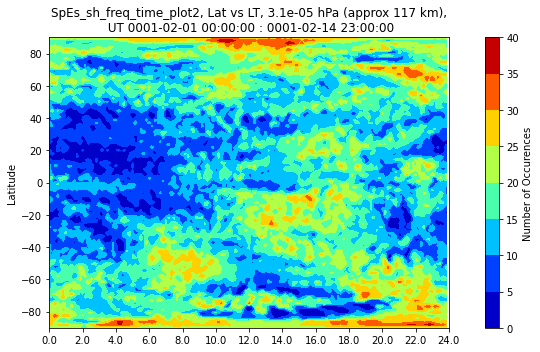

In [80]:
#---------------Set up plot variables----------------------------

SpEs_sh_freq_time_plot2 = SpEs_sh_freq_time[lev_sl_plot1_idx,:,:]

#------------------------ SpEs_sh_freq_time_plot2  -----------------------------

#ticks = np.linspace(0, 40, 21)

fig, ax = plt.subplots(figsize=(8, 5))
C = ax.contourf(timeconv_plot, lat, SpEs_sh_freq_time_plot2, 
                 #levels=ticks,
                 #locator=ticker.LogLocator(),
                 #extend='min',
                 cmap=jet)

ax.set_ylabel('Latitude')
ax.set_xticks(np.linspace(0,24,13)) 
#ax.set_xticklabels(LT_plot_ticks[::2]) 
ax.set_xticklabels(timeconv_plot_ticks[::2]) 

ax.set_title('SpEs_sh_freq_time_plot2, Lat vs LT, ' + lev_sl_plot1_str + ' (approx ' + Zavg_sl_plot1_str + '),\n UT ' + times_str_min[it2_plot] + ' : ' + times_str_max[it2_plot]  )

#------------------
def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

cbar = fig.colorbar(C, pad=0.07)#,ticks=ticks[::2])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
#-------------------

cbar.set_label(r'Number of Occurences')

figname='SpEs_sh_freq_time_plot2: Lat vs LT ' + lev_sl_plot1_str + times_str_min[it2_plot] + ' : ' + times_str_max[it2_plot] + '.png'
plt.tight_layout()
plt.savefig('./Figures/Jianfei_run/SpE_Identification/Local_Time_Plots/'+ str(Metal)+'p/Occurence_freq/'+str(figname), dpi = 300) #

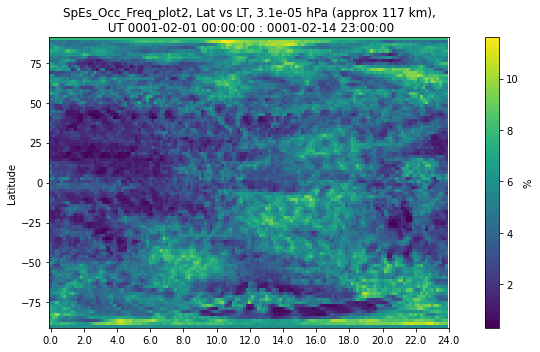

In [81]:
#---------------Set up plot variables----------------------------

SpEs_Occ_Freq_plot2 = SpEs_Occ_Freq[lev_sl_plot1_idx,:,:]

#------------------------ SpEs_sh_freq_time_plot2  -----------------------------

#ticks = np.linspace(0, 12, 13)

fig, ax = plt.subplots(figsize=(8, 5))
#C = ax.contourf(timeconv_plot, lat, SpEs_Occ_Freq_plot2, 
                 #levels=ticks,
                 #locator=ticker.LogLocator(),
                 #extend='min',
#                 cmap=jet)

C = ax.pcolormesh(timeconv_plot, lat, SpEs_Occ_Freq_plot2)

ax.set_ylabel('Latitude')
ax.set_xticks(np.linspace(0,24,13)) 
#ax.set_xticklabels(LT_plot_ticks[::2]) 
ax.set_xticklabels(timeconv_plot_ticks[::2]) 

ax.set_title('SpEs_Occ_Freq_plot2, Lat vs LT, ' + lev_sl_plot1_str + ' (approx ' + Zavg_sl_plot1_str + '),\n UT ' + times_str_min[it2_plot] + ' : ' + times_str_max[it2_plot]  )

#------------------
def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

cbar = fig.colorbar(C, pad=0.07)#,ticks=ticks[::2])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
#-------------------

cbar.set_label(r'%')

figname='SpEs_Occ_Freq_plot2: Lat vs LT ' + lev_sl_plot1_str + times_str_min[it2_plot] + ' : ' + times_str_max[it2_plot] + '.png'
plt.tight_layout()
plt.savefig('./Figures/Jianfei_run/SpE_Identification/Local_Time_Plots/'+ str(Metal)+'p/Occurence_freq/'+str(figname), dpi = 300) #

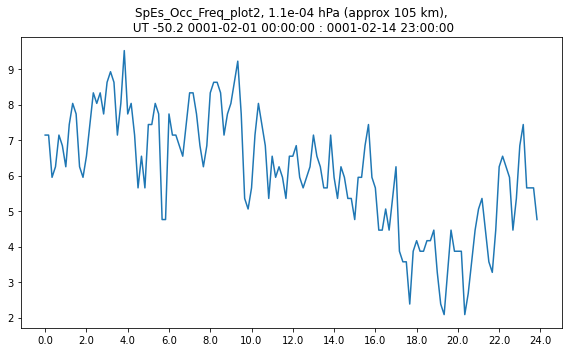

In [45]:
#---------------Set up plot variables----------------------------

SpEs_Occ_Freq_plot3 = SpEs_Occ_Freq[lev_sl_plot1_idx,lat_plot_idx,:]

#------------------------ SpEs_sh_freq_time_plot2  -----------------------------

#ticks = np.linspace(0, 12, 13)

fig, ax = plt.subplots(figsize=(8, 5))

C = ax.plot(timeconv_plot, SpEs_Occ_Freq_plot3)

#ax.set_ylabel('Latitude')
ax.set_xticks(np.linspace(0,24,13)) 
#ax.set_xticklabels(LT_plot_ticks[::2]) 
ax.set_xticklabels(timeconv_plot_ticks[::2]) 

ax.set_title('SpEs_Occ_Freq_plot2, ' + lev_sl_plot1_str + ' (approx ' + Zavg_sl_plot1_str + '),\n UT ' + lat_plot_str + ' ' + times_str_min[it2_plot] + ' : ' + times_str_max[it2_plot]  )

#------------------
def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

#cbar = fig.colorbar(C, pad=0.07)#,ticks=ticks[::2])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
#-------------------

#cbar.set_label(r'%')

figname='SpEs_Occ_Freq_plot2: ' + lev_sl_plot1_str + lat_plot_str + ' ' + times_str_min[it2_plot] + ' : ' + times_str_max[it2_plot] + '.png'
plt.tight_layout()
#plt.savefig('./Figures/Jianfei_run/SpE_Identification/Local_Time_Plots/'+ str(Metal)+'p/Occurence_freq/'+str(figname), dpi = 300) #